# Network Visualization (TensorFlow)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

This notebook uses **TensorFlow**; we have provided another notebook which explores the same concepts in PyTorch. You only need to complete one of these two notebooks.

In [1]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import preprocess_image, deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

We have ported the PyTorch SqueezeNet model to TensorFlow; see: `cs231n/classifiers/squeezenet.py` for the model architecture.

To use SqueezeNet, you will need to first **download the weights** by descending into the `cs231n/datasets` directory and running `get_squeezenet_tf.sh`. Note that if you ran `get_assignment3_data.sh` then SqueezeNet will already be downloaded.

Once you've downloaded the Squeezenet model, we can load it into a new TensorFlow session:

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [2]:
tf.reset_default_graph()
sess = get_session()

SAVE_PATH = 'cs231n/datasets/squeezenet_tf/squeezenet.ckpt'
if not os.path.exists(SAVE_PATH + ".index"):
    raise ValueError("You need to download SqueezeNet!")
model = SqueezeNet(save_path=SAVE_PATH, sess=sess)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet_tf/squeezenet.ckpt


## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. To download these images, descend into `cs231n/datasets/` and run `get_imagenet_val.sh`.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

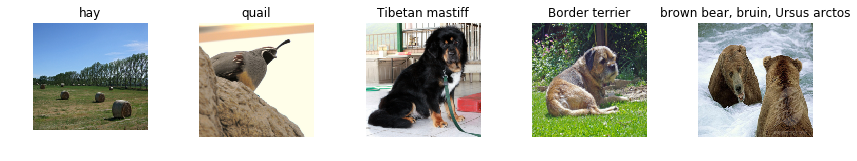

In [3]:
from cs231n.data_utils import load_imagenet_val
X_raw, y, class_names = load_imagenet_val()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_raw[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Preprocess images
The input to the pretrained model is expected to be normalized, so we first preprocess the images by subtracting the pixelwise mean and dividing by the pixelwise standard deviation.

In [103]:
X = np.array([preprocess_image(img) for img in X_raw])

In [104]:
X.shape

(25, 224, 224, 3)

# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

You will need to use the `model.scores` Tensor containing the scores for each input, and will need to feed in values for the `model.image` and `model.labels` placeholder when evaluating the gradient. Open the file `cs231n/classifiers/squeezenet.py` and read the documentation to make sure you understand how to use the model. For example usage, you can see the `loss` attribute. 

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [14]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """
    saliency = None
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    #
    # Note: this is equivalent to scores[np.arange(N), y] we used in NumPy
    # for computing vectorized losses.
    correct_scores = tf.gather_nd(model.scores,
                                  tf.stack((tf.range(X.shape[0]), model.labels), axis=1))
    ###############################################################################
    # TODO: Produce the saliency maps over a batch of images.                     #
    #                                                                             #
    # 1) Compute the “loss” using the correct scores tensor provided for you.     #
    #    (We'll combine losses across a batch by summing)                         #
    # 2) Use tf.gradients to compute the gradient of the loss with respect        #
    #    to the image (accessible via model.image).                               #
    # 3) Compute the actual value of the gradient by a call to sess.run().        #
    #    You will need to feed in values for the placeholders model.image and     #
    #    model.labels.                                                            #
    # 4) Finally, process the returned gradient to compute the saliency map.      #
    ###############################################################################
    # 1- compute loss
    loss = model.loss
    # 2- compute gradient
    gradients = tf.gradients(loss,model.image)
    # 3- compute actual value 
    gradients = sess.run(gradients,feed_dict={model.image:X,model.labels:y})
    saliency = np.max(np.abs(gradients),axis=3)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

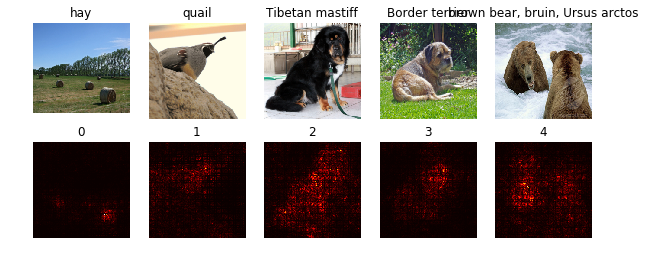

In [15]:
def show_saliency_maps(X, y, mask):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]

    saliency = compute_saliency_maps(Xm, ym, model)

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()

mask = np.arange(5)
show_saliency_maps(X, y, mask)

# INLINE QUESTION

A friend of yours suggests that in order to find an image that maximizes the correct score, we can perform gradient ascent on the input image, but instead of the gradient we can actually use the saliency map in each step to update the image. Is this assertion true? Why or why not?

# Fooling Images
We can also use image gradients to generate "fooling images" as discussed in [3]. Given an image and a target class, we can perform gradient **ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [60]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image, a numpy array of shape (1, 224, 224, 3)
    - target_y: An integer in the range [0, 1000)
    - model: Pretrained SqueezeNet model

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    
    # Make a copy of the input that we will modify
    X_fooling = X.copy()
    
    # Step size for the update
    learning_rate = 1
    
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. Use gradient *ascent* on the target class score, using #
    # the model.scores Tensor to get the class scores for the model.image.   #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop, where in each iteration, you make an     #
    # update to the input image X_fooling (don't modify X). The loop should      #
    # stop when the predicted class for the input is the same as target_y.       #
    #                                                                            #
    # HINT: It's good practice to define your TensorFlow graph operations        #
    # outside the loop, and then just make sess.run() calls in each iteration.   #
    #                                                                            #
    # HINT 2: For most examples, you should be able to generate a fooling image  #
    # in fewer than 100 iterations of gradient ascent. You can print your        #
    # progress over iterations to check your algorithm.                          #
    ##############################################################################
    correct_scores = model.scores[0]
    correct_class = tf.argmax(correct_scores)
    fooling_class_score = correct_scores[target_y]
    dimage_fooling = tf.gradients(fooling_class_score,model.image)[0]
    image_result = model.image + learning_rate * dimage_fooling/tf.norm(dimage_fooling,ord=2)
    
    for i in range(150):
        _image_result,_fooling_class_score,_correct_class = sess.run([image_result,fooling_class_score,correct_class],feed_dict={model.image:X_fooling})
        print("it %d - loss %lf - predicted %d - target %d " % (i, _fooling_class_score, _correct_class, target_y) )
        X_fooling = _image_result
        if (_correct_class == target_y):
            break
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

Run the following to generate a fooling image. You should ideally see at first glance no major difference between the original and fooling images, and the network should now make an incorrect prediction on the fooling one. However you should see a bit of random noise if you look at the 10x magnified difference between the original and fooling images. Feel free to change the `idx` variable to explore other images.

it 0 - loss 2.898788 - predicted 804 - target 8 
it 1 - loss 4.929407 - predicted 804 - target 8 
it 2 - loss 6.612202 - predicted 804 - target 8 
it 3 - loss 8.248867 - predicted 804 - target 8 
it 4 - loss 10.168385 - predicted 804 - target 8 
it 5 - loss 11.945087 - predicted 804 - target 8 
it 6 - loss 13.523732 - predicted 804 - target 8 
it 7 - loss 14.922960 - predicted 811 - target 8 
it 8 - loss 16.566513 - predicted 811 - target 8 
it 9 - loss 18.514299 - predicted 811 - target 8 
it 10 - loss 20.636587 - predicted 811 - target 8 
it 11 - loss 23.148930 - predicted 811 - target 8 
it 12 - loss 25.333406 - predicted 811 - target 8 
it 13 - loss 27.605639 - predicted 811 - target 8 
it 14 - loss 29.761387 - predicted 811 - target 8 
it 15 - loss 32.003887 - predicted 8 - target 8 


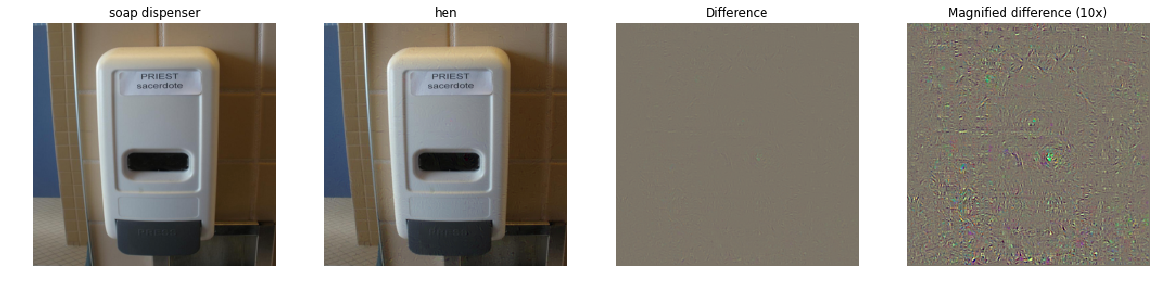

In [105]:
idx = 5
Xi = X[idx][None]
target_y = 8
X_fooling = make_fooling_image(Xi, target_y, model)

# Make sure that X_fooling is classified as y_target
scores = sess.run(model.scores, {model.image: X_fooling})
assert scores[0].argmax() == target_y, 'The network is not fooled!'

plt.rcParams['figure.figsize'] = (20.0, 12.0) # set default size of plots


# Show original image, fooling image, and difference
orig_img = deprocess_image(Xi[0])
fool_img = deprocess_image(X_fooling[0])
# Rescale 
plt.subplot(1, 4, 1)
plt.imshow(orig_img)
plt.axis('off')
plt.title(class_names[y[idx]])
plt.subplot(1, 4, 2)
plt.imshow(fool_img)
plt.title(class_names[target_y])
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title('Difference')
plt.imshow(deprocess_image((Xi-X_fooling)[0]))
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title('Magnified difference (10x)')
plt.imshow(deprocess_image(10 * (Xi-X_fooling)[0]))
plt.axis('off')
plt.show()

# Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = {\arg\max}_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [59]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    return X

In [108]:
def create_class_visualization(target_y, model, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    X_test=kwargs.pop("X_test",None)
    
    # We use a single image of random noise as a starting point
    X = 255 * np.random.rand(224, 224, 3)
    X = preprocess_image(X)[None]
    if X_test is not None:
        X = X_test
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.scores to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    correct_scores = model.scores[0]
    correct_class = tf.argmax(correct_scores)
    generated_class_score = correct_scores[target_y] - l2_reg * tf.nn.l2_loss(model.image)
    grad = tf.gradients(generated_class_score,model.image)[0]
    
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        X = np.roll(np.roll(X, ox, 1), oy, 2)
        
        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        _grad,_generated_class_score,_correct_class = sess.run([grad,generated_class_score,correct_class],feed_dict={model.image:X})
        print("it %d - loss %lf - predicted %d - target %d " % (t, _generated_class_score, _correct_class, target_y))
        X = X + learning_rate * _grad/np.linalg.norm(_grad)
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess_image(X[0]))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
    return X

Once you have completed the implementation in the cell above, run the following cell to generate an image of Tarantula:

it 0 - loss -123.107071 - predicted 735 - target 71 


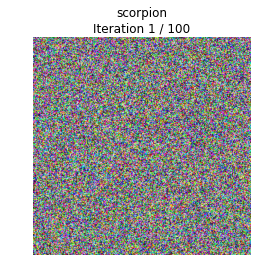

it 1 - loss -48.347820 - predicted 735 - target 71 
it 2 - loss -45.608665 - predicted 735 - target 71 
it 3 - loss -42.137127 - predicted 735 - target 71 
it 4 - loss -39.897900 - predicted 735 - target 71 
it 5 - loss -34.743095 - predicted 741 - target 71 
it 6 - loss -34.834263 - predicted 741 - target 71 
it 7 - loss -29.208212 - predicted 741 - target 71 
it 8 - loss -27.544075 - predicted 741 - target 71 
it 9 - loss -16.883249 - predicted 71 - target 71 
it 10 - loss -21.656393 - predicted 71 - target 71 
it 11 - loss 0.996746 - predicted 71 - target 71 
it 12 - loss 7.588108 - predicted 71 - target 71 
it 13 - loss 12.035294 - predicted 71 - target 71 
it 14 - loss 13.305595 - predicted 71 - target 71 
it 15 - loss 16.642344 - predicted 71 - target 71 
it 16 - loss 17.382507 - predicted 71 - target 71 
it 17 - loss 21.070791 - predicted 71 - target 71 
it 18 - loss 28.790779 - predicted 71 - target 71 
it 19 - loss 27.953981 - predicted 71 - target 71 
it 20 - loss 34.010830 -

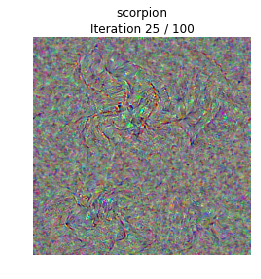

it 25 - loss 54.296967 - predicted 71 - target 71 
it 26 - loss 54.412331 - predicted 71 - target 71 
it 27 - loss 60.941154 - predicted 71 - target 71 
it 28 - loss 67.420006 - predicted 71 - target 71 
it 29 - loss 65.752686 - predicted 71 - target 71 
it 30 - loss 68.120674 - predicted 71 - target 71 
it 31 - loss 61.982517 - predicted 71 - target 71 
it 32 - loss 78.720718 - predicted 71 - target 71 
it 33 - loss 92.025482 - predicted 71 - target 71 
it 34 - loss 81.516830 - predicted 71 - target 71 
it 35 - loss 88.158569 - predicted 71 - target 71 
it 36 - loss 81.434494 - predicted 71 - target 71 
it 37 - loss 105.234169 - predicted 71 - target 71 
it 38 - loss 107.278030 - predicted 71 - target 71 
it 39 - loss 86.986916 - predicted 71 - target 71 
it 40 - loss 111.232941 - predicted 71 - target 71 
it 41 - loss 93.809448 - predicted 71 - target 71 
it 42 - loss 91.794472 - predicted 71 - target 71 
it 43 - loss 118.809799 - predicted 71 - target 71 
it 44 - loss 100.913330 - p

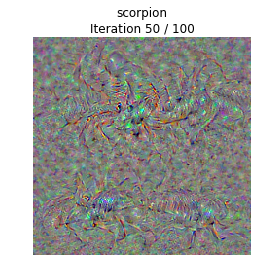

it 50 - loss 119.140671 - predicted 71 - target 71 
it 51 - loss 120.604523 - predicted 71 - target 71 
it 52 - loss 112.261429 - predicted 71 - target 71 
it 53 - loss 125.744225 - predicted 71 - target 71 
it 54 - loss 120.743538 - predicted 71 - target 71 
it 55 - loss 114.149010 - predicted 71 - target 71 
it 56 - loss 135.121628 - predicted 71 - target 71 
it 57 - loss 139.179871 - predicted 71 - target 71 
it 58 - loss 131.853348 - predicted 71 - target 71 
it 59 - loss 124.518509 - predicted 71 - target 71 
it 60 - loss 153.214111 - predicted 71 - target 71 
it 61 - loss 140.887131 - predicted 71 - target 71 
it 62 - loss 125.791901 - predicted 71 - target 71 
it 63 - loss 137.278702 - predicted 71 - target 71 
it 64 - loss 146.991699 - predicted 71 - target 71 
it 65 - loss 142.127808 - predicted 71 - target 71 
it 66 - loss 126.558762 - predicted 71 - target 71 
it 67 - loss 142.720871 - predicted 71 - target 71 
it 68 - loss 142.110474 - predicted 71 - target 71 
it 69 - loss

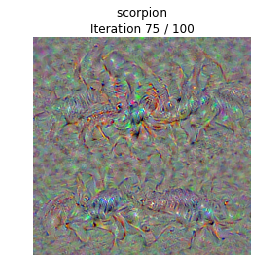

it 75 - loss 155.451050 - predicted 71 - target 71 
it 76 - loss 148.027435 - predicted 71 - target 71 
it 77 - loss 166.571899 - predicted 71 - target 71 
it 78 - loss 157.778229 - predicted 71 - target 71 
it 79 - loss 163.979752 - predicted 71 - target 71 
it 80 - loss 162.307831 - predicted 71 - target 71 
it 81 - loss 156.774521 - predicted 71 - target 71 
it 82 - loss 159.700439 - predicted 71 - target 71 
it 83 - loss 145.497284 - predicted 71 - target 71 
it 84 - loss 167.434311 - predicted 71 - target 71 
it 85 - loss 138.547729 - predicted 71 - target 71 
it 86 - loss 182.014267 - predicted 71 - target 71 
it 87 - loss 164.236343 - predicted 71 - target 71 
it 88 - loss 180.521118 - predicted 71 - target 71 
it 89 - loss 158.223511 - predicted 71 - target 71 
it 90 - loss 175.486282 - predicted 71 - target 71 
it 91 - loss 176.031570 - predicted 71 - target 71 
it 92 - loss 155.158173 - predicted 71 - target 71 
it 93 - loss 173.073669 - predicted 71 - target 71 
it 94 - loss

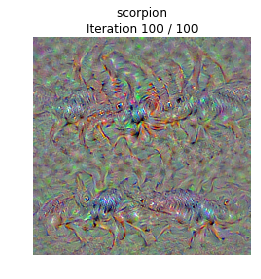

In [87]:
target_y = 71 # Tarantula
out = create_class_visualization(target_y, model)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

gorilla, Gorilla gorilla
it 0 - loss -60.434772 - predicted 751 - target 366 


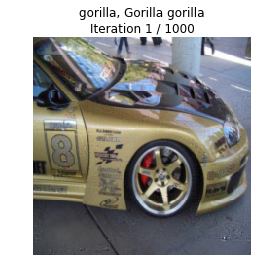

it 1 - loss -52.555477 - predicted 751 - target 366 
it 2 - loss -47.630707 - predicted 786 - target 366 
it 3 - loss -42.610683 - predicted 863 - target 366 
it 4 - loss -35.882980 - predicted 863 - target 366 
it 5 - loss -25.928226 - predicted 366 - target 366 
it 6 - loss -24.726837 - predicted 366 - target 366 
it 7 - loss -18.859692 - predicted 366 - target 366 
it 8 - loss -11.732445 - predicted 366 - target 366 
it 9 - loss -1.887623 - predicted 366 - target 366 
it 10 - loss -1.132042 - predicted 366 - target 366 
it 11 - loss 9.727779 - predicted 366 - target 366 
it 12 - loss 6.317383 - predicted 366 - target 366 
it 13 - loss 5.847469 - predicted 366 - target 366 
it 14 - loss 19.214909 - predicted 366 - target 366 
it 15 - loss 24.088493 - predicted 366 - target 366 
it 16 - loss 23.833508 - predicted 366 - target 366 
it 17 - loss 40.152851 - predicted 366 - target 366 
it 18 - loss 33.330101 - predicted 366 - target 366 
it 19 - loss 35.020489 - predicted 366 - target 36

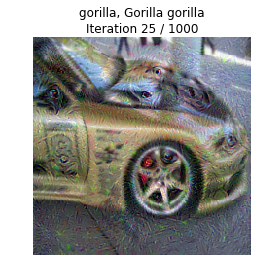

it 25 - loss 68.425522 - predicted 366 - target 366 
it 26 - loss 49.982944 - predicted 366 - target 366 
it 27 - loss 56.205494 - predicted 366 - target 366 
it 28 - loss 57.949566 - predicted 366 - target 366 
it 29 - loss 57.558876 - predicted 366 - target 366 
it 30 - loss 62.076630 - predicted 366 - target 366 
it 31 - loss 72.898430 - predicted 366 - target 366 
it 32 - loss 80.289536 - predicted 366 - target 366 
it 33 - loss 71.184647 - predicted 366 - target 366 
it 34 - loss 69.456520 - predicted 366 - target 366 
it 35 - loss 73.185944 - predicted 366 - target 366 
it 36 - loss 75.697182 - predicted 366 - target 366 
it 37 - loss 79.458817 - predicted 366 - target 366 
it 38 - loss 90.707268 - predicted 366 - target 366 
it 39 - loss 80.771866 - predicted 366 - target 366 
it 40 - loss 106.234558 - predicted 366 - target 366 
it 41 - loss 73.290146 - predicted 366 - target 366 
it 42 - loss 91.176865 - predicted 366 - target 366 
it 43 - loss 92.169785 - predicted 366 - targ

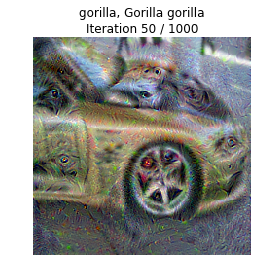

it 50 - loss 104.308182 - predicted 366 - target 366 
it 51 - loss 104.767822 - predicted 366 - target 366 
it 52 - loss 112.976578 - predicted 366 - target 366 
it 53 - loss 111.008972 - predicted 366 - target 366 
it 54 - loss 122.602798 - predicted 366 - target 366 
it 55 - loss 100.279892 - predicted 366 - target 366 
it 56 - loss 105.897293 - predicted 366 - target 366 
it 57 - loss 120.822845 - predicted 366 - target 366 
it 58 - loss 101.593338 - predicted 366 - target 366 
it 59 - loss 127.449997 - predicted 366 - target 366 
it 60 - loss 113.905663 - predicted 366 - target 366 
it 61 - loss 119.512085 - predicted 366 - target 366 
it 62 - loss 102.068893 - predicted 366 - target 366 
it 63 - loss 102.007675 - predicted 366 - target 366 
it 64 - loss 123.776047 - predicted 366 - target 366 
it 65 - loss 126.582512 - predicted 366 - target 366 
it 66 - loss 119.820030 - predicted 366 - target 366 
it 67 - loss 121.195541 - predicted 366 - target 366 
it 68 - loss 139.188919 - pr

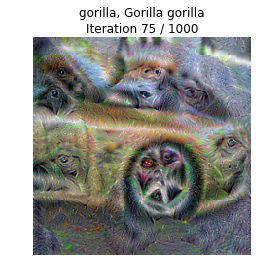

it 75 - loss 125.585251 - predicted 366 - target 366 
it 76 - loss 137.166290 - predicted 366 - target 366 
it 77 - loss 118.262238 - predicted 366 - target 366 
it 78 - loss 138.239456 - predicted 366 - target 366 
it 79 - loss 129.240891 - predicted 366 - target 366 
it 80 - loss 137.657822 - predicted 366 - target 366 
it 81 - loss 133.562500 - predicted 366 - target 366 
it 82 - loss 113.300453 - predicted 366 - target 366 
it 83 - loss 151.189850 - predicted 366 - target 366 
it 84 - loss 124.163361 - predicted 366 - target 366 
it 85 - loss 142.891846 - predicted 366 - target 366 
it 86 - loss 142.706573 - predicted 366 - target 366 
it 87 - loss 142.578094 - predicted 366 - target 366 
it 88 - loss 133.181915 - predicted 366 - target 366 
it 89 - loss 143.831329 - predicted 366 - target 366 
it 90 - loss 142.954407 - predicted 366 - target 366 
it 91 - loss 126.700500 - predicted 366 - target 366 
it 92 - loss 147.188004 - predicted 366 - target 366 
it 93 - loss 130.481140 - pr

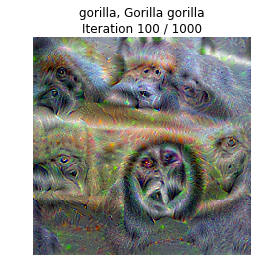

it 100 - loss 163.088898 - predicted 366 - target 366 
it 101 - loss 141.132629 - predicted 366 - target 366 
it 102 - loss 162.036102 - predicted 366 - target 366 
it 103 - loss 139.496979 - predicted 366 - target 366 
it 104 - loss 160.441818 - predicted 366 - target 366 
it 105 - loss 166.120270 - predicted 366 - target 366 
it 106 - loss 136.065399 - predicted 366 - target 366 
it 107 - loss 152.366180 - predicted 366 - target 366 
it 108 - loss 155.454819 - predicted 366 - target 366 
it 109 - loss 151.943695 - predicted 366 - target 366 
it 110 - loss 133.917786 - predicted 366 - target 366 
it 111 - loss 151.218033 - predicted 366 - target 366 
it 112 - loss 137.338516 - predicted 366 - target 366 
it 113 - loss 160.976639 - predicted 366 - target 366 
it 114 - loss 142.354843 - predicted 366 - target 366 
it 115 - loss 149.408173 - predicted 366 - target 366 
it 116 - loss 155.199036 - predicted 366 - target 366 
it 117 - loss 162.186340 - predicted 366 - target 366 
it 118 - l

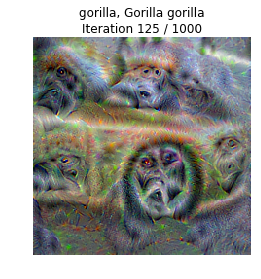

it 125 - loss 164.459320 - predicted 366 - target 366 
it 126 - loss 169.971756 - predicted 366 - target 366 
it 127 - loss 172.402771 - predicted 366 - target 366 
it 128 - loss 164.408630 - predicted 366 - target 366 
it 129 - loss 171.003540 - predicted 366 - target 366 
it 130 - loss 177.959305 - predicted 366 - target 366 
it 131 - loss 174.079895 - predicted 366 - target 366 
it 132 - loss 181.745956 - predicted 366 - target 366 
it 133 - loss 154.132782 - predicted 366 - target 366 
it 134 - loss 164.265472 - predicted 366 - target 366 
it 135 - loss 175.537872 - predicted 366 - target 366 
it 136 - loss 147.983521 - predicted 366 - target 366 
it 137 - loss 181.549881 - predicted 366 - target 366 
it 138 - loss 159.506058 - predicted 366 - target 366 
it 139 - loss 160.089127 - predicted 366 - target 366 
it 140 - loss 160.637360 - predicted 366 - target 366 
it 141 - loss 170.760605 - predicted 366 - target 366 
it 142 - loss 173.051727 - predicted 366 - target 366 
it 143 - l

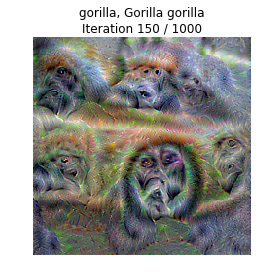

it 150 - loss 169.089050 - predicted 366 - target 366 
it 151 - loss 172.431030 - predicted 366 - target 366 
it 152 - loss 196.848145 - predicted 366 - target 366 
it 153 - loss 172.841461 - predicted 366 - target 366 
it 154 - loss 181.786804 - predicted 366 - target 366 
it 155 - loss 174.331177 - predicted 366 - target 366 
it 156 - loss 162.337097 - predicted 366 - target 366 
it 157 - loss 169.373962 - predicted 366 - target 366 
it 158 - loss 196.050903 - predicted 366 - target 366 
it 159 - loss 202.933029 - predicted 366 - target 366 
it 160 - loss 200.091217 - predicted 366 - target 366 
it 161 - loss 179.191803 - predicted 366 - target 366 
it 162 - loss 183.117889 - predicted 366 - target 366 
it 163 - loss 160.373016 - predicted 366 - target 366 
it 164 - loss 183.116852 - predicted 366 - target 366 
it 165 - loss 203.444733 - predicted 366 - target 366 
it 166 - loss 177.776398 - predicted 366 - target 366 
it 167 - loss 208.270737 - predicted 366 - target 366 
it 168 - l

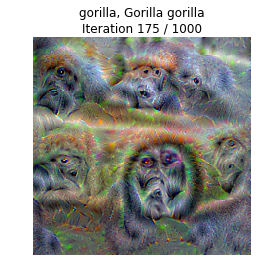

it 175 - loss 176.101471 - predicted 366 - target 366 
it 176 - loss 187.376236 - predicted 366 - target 366 
it 177 - loss 184.548996 - predicted 366 - target 366 
it 178 - loss 194.278381 - predicted 366 - target 366 
it 179 - loss 188.006653 - predicted 366 - target 366 
it 180 - loss 169.402206 - predicted 366 - target 366 
it 181 - loss 179.776062 - predicted 366 - target 366 
it 182 - loss 188.843048 - predicted 366 - target 366 
it 183 - loss 190.944763 - predicted 366 - target 366 
it 184 - loss 163.604156 - predicted 366 - target 366 
it 185 - loss 203.674011 - predicted 366 - target 366 
it 186 - loss 171.447021 - predicted 366 - target 366 
it 187 - loss 198.130753 - predicted 366 - target 366 
it 188 - loss 192.714203 - predicted 366 - target 366 
it 189 - loss 207.622559 - predicted 366 - target 366 
it 190 - loss 190.273911 - predicted 366 - target 366 
it 191 - loss 171.091278 - predicted 366 - target 366 
it 192 - loss 200.987701 - predicted 366 - target 366 
it 193 - l

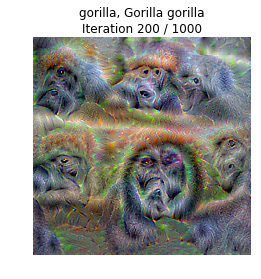

it 200 - loss 200.823090 - predicted 366 - target 366 
it 201 - loss 172.016266 - predicted 366 - target 366 
it 202 - loss 192.931778 - predicted 366 - target 366 
it 203 - loss 197.743011 - predicted 366 - target 366 
it 204 - loss 206.225189 - predicted 366 - target 366 
it 205 - loss 194.634125 - predicted 366 - target 366 
it 206 - loss 182.332031 - predicted 366 - target 366 
it 207 - loss 184.434067 - predicted 366 - target 366 
it 208 - loss 194.369812 - predicted 366 - target 366 
it 209 - loss 204.610199 - predicted 366 - target 366 
it 210 - loss 196.885498 - predicted 366 - target 366 
it 211 - loss 189.755188 - predicted 366 - target 366 
it 212 - loss 200.327545 - predicted 366 - target 366 
it 213 - loss 202.892532 - predicted 366 - target 366 
it 214 - loss 188.041473 - predicted 366 - target 366 
it 215 - loss 218.931641 - predicted 366 - target 366 
it 216 - loss 186.720428 - predicted 366 - target 366 
it 217 - loss 213.961044 - predicted 366 - target 366 
it 218 - l

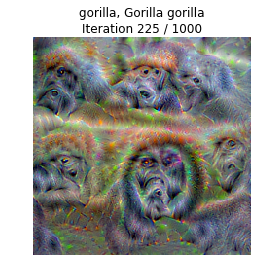

it 225 - loss 196.444107 - predicted 366 - target 366 
it 226 - loss 184.134796 - predicted 366 - target 366 
it 227 - loss 207.338379 - predicted 366 - target 366 
it 228 - loss 208.038925 - predicted 366 - target 366 
it 229 - loss 203.027283 - predicted 366 - target 366 
it 230 - loss 230.198318 - predicted 366 - target 366 
it 231 - loss 197.780014 - predicted 366 - target 366 
it 232 - loss 182.378220 - predicted 366 - target 366 
it 233 - loss 213.402466 - predicted 366 - target 366 
it 234 - loss 203.479691 - predicted 366 - target 366 
it 235 - loss 215.009872 - predicted 366 - target 366 
it 236 - loss 206.064102 - predicted 366 - target 366 
it 237 - loss 193.721741 - predicted 366 - target 366 
it 238 - loss 201.067032 - predicted 366 - target 366 
it 239 - loss 218.486557 - predicted 366 - target 366 
it 240 - loss 196.690125 - predicted 366 - target 366 
it 241 - loss 199.176773 - predicted 366 - target 366 
it 242 - loss 205.561722 - predicted 366 - target 366 
it 243 - l

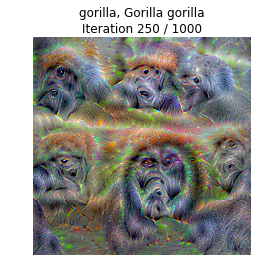

it 250 - loss 216.526077 - predicted 366 - target 366 
it 251 - loss 212.372589 - predicted 366 - target 366 
it 252 - loss 194.055908 - predicted 366 - target 366 
it 253 - loss 227.586823 - predicted 366 - target 366 
it 254 - loss 201.518982 - predicted 366 - target 366 
it 255 - loss 214.914108 - predicted 366 - target 366 
it 256 - loss 218.019958 - predicted 366 - target 366 
it 257 - loss 198.437119 - predicted 366 - target 366 
it 258 - loss 222.271530 - predicted 366 - target 366 
it 259 - loss 215.835648 - predicted 366 - target 366 
it 260 - loss 225.502640 - predicted 366 - target 366 
it 261 - loss 198.764587 - predicted 366 - target 366 
it 262 - loss 196.666595 - predicted 366 - target 366 
it 263 - loss 223.606903 - predicted 366 - target 366 
it 264 - loss 225.715393 - predicted 366 - target 366 
it 265 - loss 221.761810 - predicted 366 - target 366 
it 266 - loss 220.513031 - predicted 366 - target 366 
it 267 - loss 219.021011 - predicted 366 - target 366 
it 268 - l

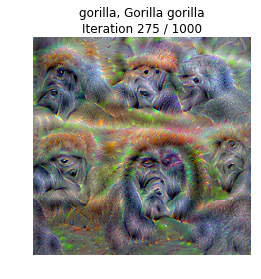

it 275 - loss 218.753937 - predicted 366 - target 366 
it 276 - loss 227.449524 - predicted 366 - target 366 
it 277 - loss 216.348923 - predicted 366 - target 366 
it 278 - loss 219.040207 - predicted 366 - target 366 
it 279 - loss 206.522217 - predicted 366 - target 366 
it 280 - loss 204.531097 - predicted 366 - target 366 
it 281 - loss 204.677856 - predicted 366 - target 366 
it 282 - loss 220.442047 - predicted 366 - target 366 
it 283 - loss 199.930908 - predicted 366 - target 366 
it 284 - loss 205.922150 - predicted 366 - target 366 
it 285 - loss 201.201263 - predicted 366 - target 366 
it 286 - loss 199.418762 - predicted 366 - target 366 
it 287 - loss 212.956375 - predicted 366 - target 366 
it 288 - loss 230.729401 - predicted 366 - target 366 
it 289 - loss 211.738708 - predicted 366 - target 366 
it 290 - loss 238.881973 - predicted 366 - target 366 
it 291 - loss 227.173599 - predicted 366 - target 366 
it 292 - loss 220.925064 - predicted 366 - target 366 
it 293 - l

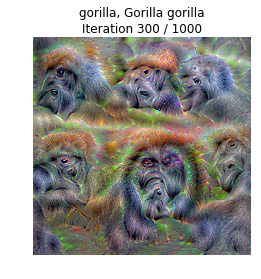

it 300 - loss 235.032654 - predicted 366 - target 366 
it 301 - loss 200.744171 - predicted 366 - target 366 
it 302 - loss 221.897552 - predicted 366 - target 366 
it 303 - loss 202.820801 - predicted 366 - target 366 
it 304 - loss 225.748093 - predicted 366 - target 366 
it 305 - loss 226.055344 - predicted 366 - target 366 
it 306 - loss 214.486862 - predicted 366 - target 366 
it 307 - loss 224.865601 - predicted 366 - target 366 
it 308 - loss 229.735062 - predicted 366 - target 366 
it 309 - loss 242.607483 - predicted 366 - target 366 
it 310 - loss 236.934418 - predicted 366 - target 366 
it 311 - loss 212.350647 - predicted 366 - target 366 
it 312 - loss 213.940613 - predicted 366 - target 366 
it 313 - loss 214.795059 - predicted 366 - target 366 
it 314 - loss 205.517288 - predicted 366 - target 366 
it 315 - loss 234.096100 - predicted 366 - target 366 
it 316 - loss 230.166870 - predicted 366 - target 366 
it 317 - loss 244.926788 - predicted 366 - target 366 
it 318 - l

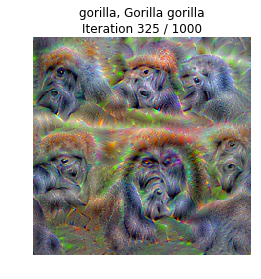

it 325 - loss 224.024780 - predicted 366 - target 366 
it 326 - loss 242.392212 - predicted 366 - target 366 
it 327 - loss 241.849762 - predicted 366 - target 366 
it 328 - loss 231.900391 - predicted 366 - target 366 
it 329 - loss 232.483841 - predicted 366 - target 366 
it 330 - loss 225.787659 - predicted 366 - target 366 
it 331 - loss 225.836975 - predicted 366 - target 366 
it 332 - loss 240.981842 - predicted 366 - target 366 
it 333 - loss 240.616653 - predicted 366 - target 366 
it 334 - loss 205.269180 - predicted 366 - target 366 
it 335 - loss 217.537628 - predicted 366 - target 366 
it 336 - loss 235.220337 - predicted 366 - target 366 
it 337 - loss 215.267960 - predicted 366 - target 366 
it 338 - loss 234.517624 - predicted 366 - target 366 
it 339 - loss 236.961105 - predicted 366 - target 366 
it 340 - loss 227.221649 - predicted 366 - target 366 
it 341 - loss 236.677017 - predicted 366 - target 366 
it 342 - loss 227.963379 - predicted 366 - target 366 
it 343 - l

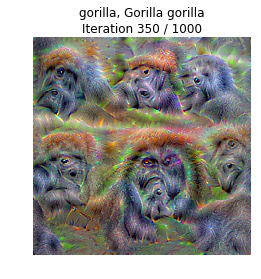

it 350 - loss 233.624939 - predicted 366 - target 366 
it 351 - loss 232.670578 - predicted 366 - target 366 
it 352 - loss 223.726654 - predicted 366 - target 366 
it 353 - loss 236.056976 - predicted 366 - target 366 
it 354 - loss 227.375504 - predicted 366 - target 366 
it 355 - loss 224.091385 - predicted 366 - target 366 
it 356 - loss 234.716370 - predicted 366 - target 366 
it 357 - loss 225.892731 - predicted 366 - target 366 
it 358 - loss 224.207855 - predicted 366 - target 366 
it 359 - loss 229.110138 - predicted 366 - target 366 
it 360 - loss 257.800110 - predicted 366 - target 366 
it 361 - loss 231.411682 - predicted 366 - target 366 
it 362 - loss 223.874329 - predicted 366 - target 366 
it 363 - loss 235.744064 - predicted 366 - target 366 
it 364 - loss 252.562561 - predicted 366 - target 366 
it 365 - loss 224.330399 - predicted 366 - target 366 
it 366 - loss 228.792068 - predicted 366 - target 366 
it 367 - loss 228.768677 - predicted 366 - target 366 
it 368 - l

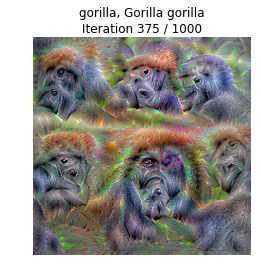

it 375 - loss 232.579300 - predicted 366 - target 366 
it 376 - loss 219.989227 - predicted 366 - target 366 
it 377 - loss 240.687347 - predicted 366 - target 366 
it 378 - loss 242.855225 - predicted 366 - target 366 
it 379 - loss 249.877960 - predicted 366 - target 366 
it 380 - loss 242.293854 - predicted 366 - target 366 
it 381 - loss 229.848679 - predicted 366 - target 366 
it 382 - loss 236.297989 - predicted 366 - target 366 
it 383 - loss 231.701111 - predicted 366 - target 366 
it 384 - loss 231.467880 - predicted 366 - target 366 
it 385 - loss 244.033493 - predicted 366 - target 366 
it 386 - loss 254.483170 - predicted 366 - target 366 
it 387 - loss 235.434418 - predicted 366 - target 366 
it 388 - loss 232.848907 - predicted 366 - target 366 
it 389 - loss 244.033203 - predicted 366 - target 366 
it 390 - loss 254.853516 - predicted 366 - target 366 
it 391 - loss 220.896667 - predicted 366 - target 366 
it 392 - loss 244.524734 - predicted 366 - target 366 
it 393 - l

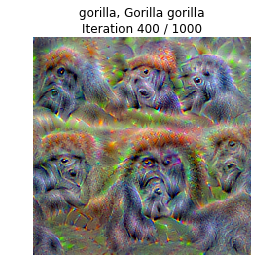

it 400 - loss 236.763565 - predicted 366 - target 366 
it 401 - loss 230.771851 - predicted 366 - target 366 
it 402 - loss 237.127365 - predicted 366 - target 366 
it 403 - loss 245.904236 - predicted 366 - target 366 
it 404 - loss 245.186829 - predicted 366 - target 366 
it 405 - loss 238.129623 - predicted 366 - target 366 
it 406 - loss 232.792191 - predicted 366 - target 366 
it 407 - loss 251.216461 - predicted 366 - target 366 
it 408 - loss 226.857666 - predicted 366 - target 366 
it 409 - loss 246.359451 - predicted 366 - target 366 
it 410 - loss 261.883209 - predicted 366 - target 366 
it 411 - loss 239.335205 - predicted 366 - target 366 
it 412 - loss 239.221054 - predicted 366 - target 366 
it 413 - loss 240.306168 - predicted 366 - target 366 
it 414 - loss 244.875870 - predicted 366 - target 366 
it 415 - loss 241.655579 - predicted 366 - target 366 
it 416 - loss 235.385178 - predicted 366 - target 366 
it 417 - loss 220.624405 - predicted 366 - target 366 
it 418 - l

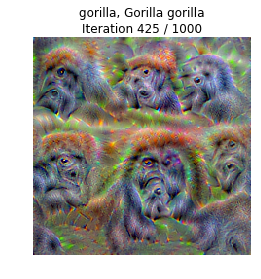

it 425 - loss 243.846558 - predicted 366 - target 366 
it 426 - loss 244.318481 - predicted 366 - target 366 
it 427 - loss 236.049026 - predicted 366 - target 366 
it 428 - loss 253.365784 - predicted 366 - target 366 
it 429 - loss 248.899246 - predicted 366 - target 366 
it 430 - loss 244.667953 - predicted 366 - target 366 
it 431 - loss 231.543045 - predicted 366 - target 366 
it 432 - loss 224.856262 - predicted 366 - target 366 
it 433 - loss 244.838516 - predicted 366 - target 366 
it 434 - loss 246.317947 - predicted 366 - target 366 
it 435 - loss 254.714325 - predicted 366 - target 366 
it 436 - loss 263.587036 - predicted 366 - target 366 
it 437 - loss 241.880707 - predicted 366 - target 366 
it 438 - loss 253.644897 - predicted 366 - target 366 
it 439 - loss 250.289764 - predicted 366 - target 366 
it 440 - loss 262.384277 - predicted 366 - target 366 
it 441 - loss 224.440308 - predicted 366 - target 366 
it 442 - loss 236.178528 - predicted 366 - target 366 
it 443 - l

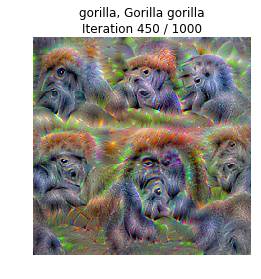

it 450 - loss 262.023438 - predicted 366 - target 366 
it 451 - loss 247.258270 - predicted 366 - target 366 
it 452 - loss 239.456436 - predicted 366 - target 366 
it 453 - loss 248.374207 - predicted 366 - target 366 
it 454 - loss 258.446777 - predicted 366 - target 366 
it 455 - loss 255.314606 - predicted 366 - target 366 
it 456 - loss 254.569824 - predicted 366 - target 366 
it 457 - loss 251.501740 - predicted 366 - target 366 
it 458 - loss 248.563904 - predicted 366 - target 366 
it 459 - loss 269.158722 - predicted 366 - target 366 
it 460 - loss 261.914337 - predicted 366 - target 366 
it 461 - loss 248.446106 - predicted 366 - target 366 
it 462 - loss 273.946655 - predicted 366 - target 366 
it 463 - loss 239.870880 - predicted 366 - target 366 
it 464 - loss 256.359009 - predicted 366 - target 366 
it 465 - loss 275.037292 - predicted 366 - target 366 
it 466 - loss 266.328308 - predicted 366 - target 366 
it 467 - loss 252.511734 - predicted 366 - target 366 
it 468 - l

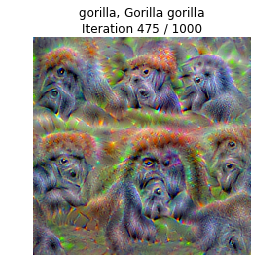

it 475 - loss 256.926331 - predicted 366 - target 366 
it 476 - loss 244.341461 - predicted 366 - target 366 
it 477 - loss 251.881088 - predicted 366 - target 366 
it 478 - loss 252.362640 - predicted 366 - target 366 
it 479 - loss 285.339691 - predicted 366 - target 366 
it 480 - loss 250.988434 - predicted 366 - target 366 
it 481 - loss 253.657883 - predicted 366 - target 366 
it 482 - loss 245.379257 - predicted 366 - target 366 
it 483 - loss 245.272369 - predicted 366 - target 366 
it 484 - loss 247.546005 - predicted 366 - target 366 
it 485 - loss 242.245758 - predicted 366 - target 366 
it 486 - loss 247.307816 - predicted 366 - target 366 
it 487 - loss 268.508301 - predicted 366 - target 366 
it 488 - loss 249.937073 - predicted 366 - target 366 
it 489 - loss 258.749756 - predicted 366 - target 366 
it 490 - loss 266.438660 - predicted 366 - target 366 
it 491 - loss 245.392609 - predicted 366 - target 366 
it 492 - loss 247.324799 - predicted 366 - target 366 
it 493 - l

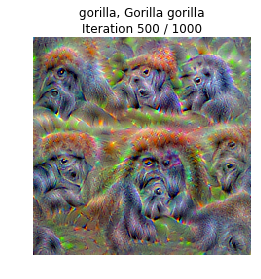

it 500 - loss 277.636780 - predicted 366 - target 366 
it 501 - loss 260.284515 - predicted 366 - target 366 
it 502 - loss 251.796783 - predicted 366 - target 366 
it 503 - loss 257.863770 - predicted 366 - target 366 
it 504 - loss 266.867493 - predicted 366 - target 366 
it 505 - loss 241.700012 - predicted 366 - target 366 
it 506 - loss 258.343689 - predicted 366 - target 366 
it 507 - loss 246.718323 - predicted 366 - target 366 
it 508 - loss 256.618134 - predicted 366 - target 366 
it 509 - loss 282.421570 - predicted 366 - target 366 
it 510 - loss 285.743744 - predicted 366 - target 366 
it 511 - loss 255.515656 - predicted 366 - target 366 
it 512 - loss 250.684433 - predicted 366 - target 366 
it 513 - loss 245.483002 - predicted 366 - target 366 
it 514 - loss 263.450989 - predicted 366 - target 366 
it 515 - loss 272.876770 - predicted 366 - target 366 
it 516 - loss 264.495819 - predicted 366 - target 366 
it 517 - loss 263.869843 - predicted 366 - target 366 
it 518 - l

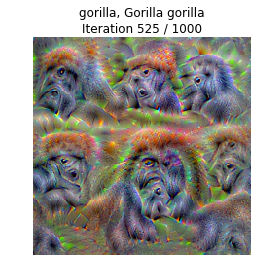

it 525 - loss 259.525970 - predicted 366 - target 366 
it 526 - loss 278.273010 - predicted 366 - target 366 
it 527 - loss 247.015015 - predicted 366 - target 366 
it 528 - loss 267.071320 - predicted 366 - target 366 
it 529 - loss 269.151489 - predicted 366 - target 366 
it 530 - loss 255.835419 - predicted 366 - target 366 
it 531 - loss 258.535522 - predicted 366 - target 366 
it 532 - loss 258.757660 - predicted 366 - target 366 
it 533 - loss 245.684021 - predicted 366 - target 366 
it 534 - loss 244.842072 - predicted 366 - target 366 
it 535 - loss 256.306427 - predicted 366 - target 366 
it 536 - loss 269.299561 - predicted 366 - target 366 
it 537 - loss 248.844711 - predicted 366 - target 366 
it 538 - loss 249.326859 - predicted 366 - target 366 
it 539 - loss 272.198883 - predicted 366 - target 366 
it 540 - loss 268.222717 - predicted 366 - target 366 
it 541 - loss 261.201843 - predicted 366 - target 366 
it 542 - loss 255.309357 - predicted 366 - target 366 
it 543 - l

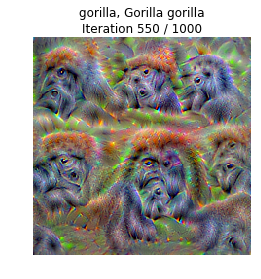

it 550 - loss 263.946075 - predicted 366 - target 366 
it 551 - loss 262.203735 - predicted 366 - target 366 
it 552 - loss 251.292099 - predicted 366 - target 366 
it 553 - loss 262.013885 - predicted 366 - target 366 
it 554 - loss 263.961029 - predicted 366 - target 366 
it 555 - loss 273.080933 - predicted 366 - target 366 
it 556 - loss 262.479431 - predicted 366 - target 366 
it 557 - loss 282.673889 - predicted 366 - target 366 
it 558 - loss 268.079651 - predicted 366 - target 366 
it 559 - loss 288.626434 - predicted 366 - target 366 
it 560 - loss 261.887085 - predicted 366 - target 366 
it 561 - loss 230.803162 - predicted 366 - target 366 
it 562 - loss 254.439697 - predicted 366 - target 366 
it 563 - loss 271.409332 - predicted 366 - target 366 
it 564 - loss 246.780807 - predicted 366 - target 366 
it 565 - loss 270.045898 - predicted 366 - target 366 
it 566 - loss 265.836426 - predicted 366 - target 366 
it 567 - loss 268.397186 - predicted 366 - target 366 
it 568 - l

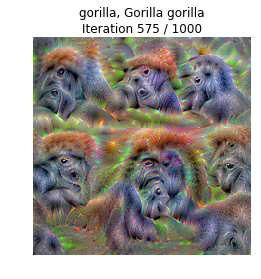

it 575 - loss 265.466461 - predicted 366 - target 366 
it 576 - loss 281.833130 - predicted 366 - target 366 
it 577 - loss 292.864197 - predicted 366 - target 366 
it 578 - loss 249.957397 - predicted 366 - target 366 
it 579 - loss 256.978088 - predicted 366 - target 366 
it 580 - loss 253.663666 - predicted 366 - target 366 
it 581 - loss 272.166504 - predicted 366 - target 366 
it 582 - loss 263.357819 - predicted 366 - target 366 
it 583 - loss 261.140747 - predicted 366 - target 366 
it 584 - loss 264.742798 - predicted 366 - target 366 
it 585 - loss 247.395676 - predicted 366 - target 366 
it 586 - loss 266.630432 - predicted 366 - target 366 
it 587 - loss 279.368408 - predicted 366 - target 366 
it 588 - loss 242.216431 - predicted 366 - target 366 
it 589 - loss 265.618256 - predicted 366 - target 366 
it 590 - loss 292.374329 - predicted 366 - target 366 
it 591 - loss 260.489685 - predicted 366 - target 366 
it 592 - loss 249.591995 - predicted 366 - target 366 
it 593 - l

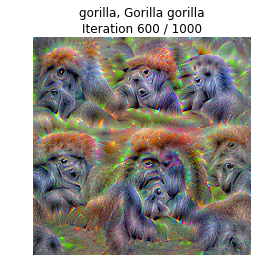

it 600 - loss 277.161621 - predicted 366 - target 366 
it 601 - loss 257.666656 - predicted 366 - target 366 
it 602 - loss 251.396378 - predicted 366 - target 366 
it 603 - loss 259.107452 - predicted 366 - target 366 
it 604 - loss 264.671326 - predicted 366 - target 366 
it 605 - loss 248.916031 - predicted 366 - target 366 
it 606 - loss 266.918365 - predicted 366 - target 366 
it 607 - loss 257.506073 - predicted 366 - target 366 
it 608 - loss 284.264282 - predicted 366 - target 366 
it 609 - loss 264.430054 - predicted 366 - target 366 
it 610 - loss 259.417725 - predicted 366 - target 366 
it 611 - loss 276.453979 - predicted 366 - target 366 
it 612 - loss 250.507874 - predicted 366 - target 366 
it 613 - loss 262.044312 - predicted 366 - target 366 
it 614 - loss 269.124634 - predicted 366 - target 366 
it 615 - loss 270.601990 - predicted 366 - target 366 
it 616 - loss 264.614166 - predicted 366 - target 366 
it 617 - loss 265.625122 - predicted 366 - target 366 
it 618 - l

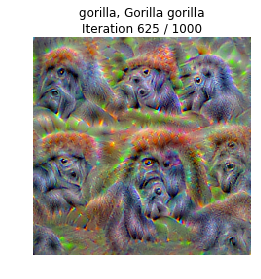

it 625 - loss 270.957916 - predicted 366 - target 366 
it 626 - loss 257.030090 - predicted 366 - target 366 
it 627 - loss 265.009277 - predicted 366 - target 366 
it 628 - loss 261.183289 - predicted 366 - target 366 
it 629 - loss 264.187775 - predicted 366 - target 366 
it 630 - loss 268.297058 - predicted 366 - target 366 
it 631 - loss 242.718369 - predicted 366 - target 366 
it 632 - loss 272.132935 - predicted 366 - target 366 
it 633 - loss 267.606232 - predicted 366 - target 366 
it 634 - loss 264.079926 - predicted 366 - target 366 
it 635 - loss 284.939514 - predicted 366 - target 366 
it 636 - loss 248.332397 - predicted 366 - target 366 
it 637 - loss 270.246643 - predicted 366 - target 366 
it 638 - loss 270.613098 - predicted 366 - target 366 
it 639 - loss 273.124207 - predicted 366 - target 366 
it 640 - loss 257.190674 - predicted 366 - target 366 
it 641 - loss 261.594543 - predicted 366 - target 366 
it 642 - loss 267.082306 - predicted 366 - target 366 
it 643 - l

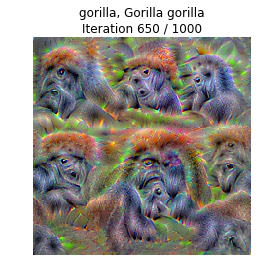

it 650 - loss 276.757355 - predicted 366 - target 366 
it 651 - loss 280.894440 - predicted 366 - target 366 
it 652 - loss 258.035797 - predicted 366 - target 366 
it 653 - loss 282.495911 - predicted 366 - target 366 
it 654 - loss 264.953125 - predicted 366 - target 366 
it 655 - loss 274.212128 - predicted 366 - target 366 
it 656 - loss 293.893616 - predicted 366 - target 366 
it 657 - loss 281.541626 - predicted 366 - target 366 
it 658 - loss 264.500031 - predicted 366 - target 366 
it 659 - loss 274.040131 - predicted 366 - target 366 
it 660 - loss 294.642639 - predicted 366 - target 366 
it 661 - loss 271.748352 - predicted 366 - target 366 
it 662 - loss 273.481415 - predicted 366 - target 366 
it 663 - loss 282.656342 - predicted 366 - target 366 
it 664 - loss 267.897003 - predicted 366 - target 366 
it 665 - loss 258.809387 - predicted 366 - target 366 
it 666 - loss 290.356079 - predicted 366 - target 366 
it 667 - loss 266.402557 - predicted 366 - target 366 
it 668 - l

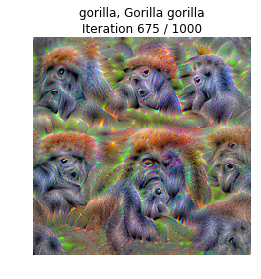

it 675 - loss 280.842896 - predicted 366 - target 366 
it 676 - loss 273.749298 - predicted 366 - target 366 
it 677 - loss 270.386780 - predicted 366 - target 366 
it 678 - loss 272.748932 - predicted 366 - target 366 
it 679 - loss 279.125549 - predicted 366 - target 366 
it 680 - loss 269.226624 - predicted 366 - target 366 
it 681 - loss 271.957062 - predicted 366 - target 366 
it 682 - loss 257.709839 - predicted 366 - target 366 
it 683 - loss 254.426529 - predicted 366 - target 366 
it 684 - loss 267.748962 - predicted 366 - target 366 
it 685 - loss 262.299835 - predicted 366 - target 366 
it 686 - loss 273.448334 - predicted 366 - target 366 
it 687 - loss 283.828278 - predicted 366 - target 366 
it 688 - loss 260.330688 - predicted 366 - target 366 
it 689 - loss 280.597107 - predicted 366 - target 366 
it 690 - loss 300.467377 - predicted 366 - target 366 
it 691 - loss 275.049530 - predicted 366 - target 366 
it 692 - loss 265.350403 - predicted 366 - target 366 
it 693 - l

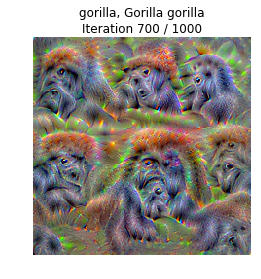

it 700 - loss 294.726440 - predicted 366 - target 366 
it 701 - loss 253.802841 - predicted 366 - target 366 
it 702 - loss 282.632080 - predicted 366 - target 366 
it 703 - loss 277.653839 - predicted 366 - target 366 
it 704 - loss 287.914520 - predicted 366 - target 366 
it 705 - loss 284.134735 - predicted 366 - target 366 
it 706 - loss 253.850006 - predicted 366 - target 366 
it 707 - loss 281.252045 - predicted 366 - target 366 
it 708 - loss 257.022766 - predicted 366 - target 366 
it 709 - loss 284.538544 - predicted 366 - target 366 
it 710 - loss 277.937469 - predicted 366 - target 366 
it 711 - loss 266.675079 - predicted 366 - target 366 
it 712 - loss 268.525269 - predicted 366 - target 366 
it 713 - loss 275.046265 - predicted 366 - target 366 
it 714 - loss 260.015991 - predicted 366 - target 366 
it 715 - loss 284.893311 - predicted 366 - target 366 
it 716 - loss 284.919525 - predicted 366 - target 366 
it 717 - loss 258.350739 - predicted 366 - target 366 
it 718 - l

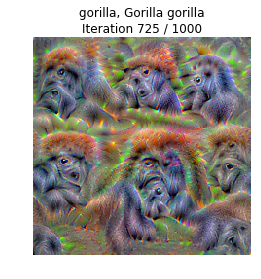

it 725 - loss 294.465332 - predicted 366 - target 366 
it 726 - loss 276.046967 - predicted 366 - target 366 
it 727 - loss 288.969910 - predicted 366 - target 366 
it 728 - loss 263.765472 - predicted 366 - target 366 
it 729 - loss 269.112854 - predicted 366 - target 366 
it 730 - loss 292.100677 - predicted 366 - target 366 
it 731 - loss 275.686890 - predicted 366 - target 366 
it 732 - loss 274.159790 - predicted 366 - target 366 
it 733 - loss 266.792755 - predicted 366 - target 366 
it 734 - loss 265.814941 - predicted 366 - target 366 
it 735 - loss 283.781799 - predicted 366 - target 366 
it 736 - loss 285.432556 - predicted 366 - target 366 
it 737 - loss 279.310303 - predicted 366 - target 366 
it 738 - loss 302.100342 - predicted 366 - target 366 
it 739 - loss 287.193878 - predicted 366 - target 366 
it 740 - loss 289.030273 - predicted 366 - target 366 
it 741 - loss 266.133820 - predicted 366 - target 366 
it 742 - loss 276.558105 - predicted 366 - target 366 
it 743 - l

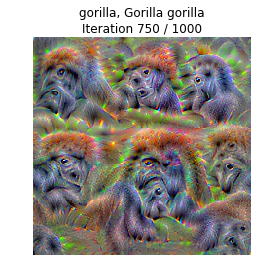

it 750 - loss 278.299957 - predicted 366 - target 366 
it 751 - loss 277.887085 - predicted 366 - target 366 
it 752 - loss 270.887238 - predicted 366 - target 366 
it 753 - loss 261.969330 - predicted 366 - target 366 
it 754 - loss 264.678192 - predicted 366 - target 366 
it 755 - loss 283.247986 - predicted 366 - target 366 
it 756 - loss 275.014771 - predicted 366 - target 366 
it 757 - loss 281.331421 - predicted 366 - target 366 
it 758 - loss 265.942017 - predicted 366 - target 366 
it 759 - loss 269.972137 - predicted 366 - target 366 
it 760 - loss 268.330444 - predicted 366 - target 366 
it 761 - loss 283.659424 - predicted 366 - target 366 
it 762 - loss 263.669220 - predicted 366 - target 366 
it 763 - loss 274.174957 - predicted 366 - target 366 
it 764 - loss 272.395111 - predicted 366 - target 366 
it 765 - loss 265.347809 - predicted 366 - target 366 
it 766 - loss 265.298187 - predicted 366 - target 366 
it 767 - loss 263.807861 - predicted 366 - target 366 
it 768 - l

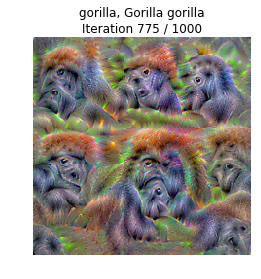

it 775 - loss 280.448730 - predicted 366 - target 366 
it 776 - loss 263.099335 - predicted 366 - target 366 
it 777 - loss 286.946350 - predicted 366 - target 366 
it 778 - loss 294.867493 - predicted 366 - target 366 
it 779 - loss 279.074036 - predicted 366 - target 366 
it 780 - loss 289.640045 - predicted 366 - target 366 
it 781 - loss 278.449463 - predicted 366 - target 366 
it 782 - loss 260.458038 - predicted 366 - target 366 
it 783 - loss 278.971832 - predicted 366 - target 366 
it 784 - loss 269.616547 - predicted 366 - target 366 
it 785 - loss 276.916718 - predicted 366 - target 366 
it 786 - loss 290.618500 - predicted 366 - target 366 
it 787 - loss 285.169495 - predicted 366 - target 366 
it 788 - loss 291.036255 - predicted 366 - target 366 
it 789 - loss 284.126099 - predicted 366 - target 366 
it 790 - loss 298.742157 - predicted 366 - target 366 
it 791 - loss 279.262421 - predicted 366 - target 366 
it 792 - loss 283.358337 - predicted 366 - target 366 
it 793 - l

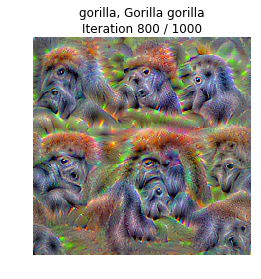

it 800 - loss 287.189545 - predicted 366 - target 366 
it 801 - loss 271.359802 - predicted 366 - target 366 
it 802 - loss 284.606171 - predicted 366 - target 366 
it 803 - loss 294.303040 - predicted 366 - target 366 
it 804 - loss 289.833252 - predicted 366 - target 366 
it 805 - loss 263.294678 - predicted 366 - target 366 
it 806 - loss 293.916748 - predicted 366 - target 366 
it 807 - loss 293.133636 - predicted 366 - target 366 
it 808 - loss 278.197662 - predicted 366 - target 366 
it 809 - loss 293.718353 - predicted 366 - target 366 
it 810 - loss 287.994934 - predicted 366 - target 366 
it 811 - loss 278.510559 - predicted 366 - target 366 
it 812 - loss 284.012299 - predicted 366 - target 366 
it 813 - loss 268.776825 - predicted 366 - target 366 
it 814 - loss 272.126648 - predicted 366 - target 366 
it 815 - loss 286.438477 - predicted 366 - target 366 
it 816 - loss 261.006836 - predicted 366 - target 366 
it 817 - loss 273.119720 - predicted 366 - target 366 
it 818 - l

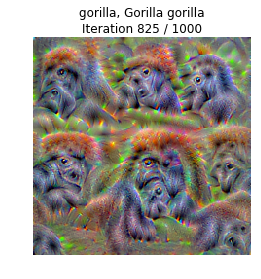

it 825 - loss 299.124420 - predicted 366 - target 366 
it 826 - loss 267.871155 - predicted 366 - target 366 
it 827 - loss 281.333984 - predicted 366 - target 366 
it 828 - loss 295.352295 - predicted 366 - target 366 
it 829 - loss 289.636719 - predicted 366 - target 366 
it 830 - loss 296.576172 - predicted 366 - target 366 
it 831 - loss 263.135590 - predicted 366 - target 366 
it 832 - loss 277.635468 - predicted 366 - target 366 
it 833 - loss 274.847656 - predicted 366 - target 366 
it 834 - loss 268.440460 - predicted 366 - target 366 
it 835 - loss 271.057037 - predicted 366 - target 366 
it 836 - loss 295.452362 - predicted 366 - target 366 
it 837 - loss 265.720856 - predicted 366 - target 366 
it 838 - loss 287.764862 - predicted 366 - target 366 
it 839 - loss 282.728058 - predicted 366 - target 366 
it 840 - loss 282.668518 - predicted 366 - target 366 
it 841 - loss 270.405518 - predicted 366 - target 366 
it 842 - loss 271.504852 - predicted 366 - target 366 
it 843 - l

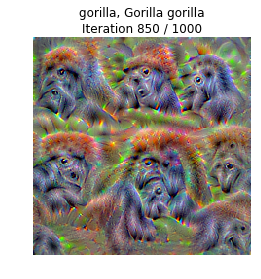

it 850 - loss 285.595154 - predicted 366 - target 366 
it 851 - loss 281.807556 - predicted 366 - target 366 
it 852 - loss 277.829803 - predicted 366 - target 366 
it 853 - loss 277.693054 - predicted 366 - target 366 
it 854 - loss 282.113495 - predicted 366 - target 366 
it 855 - loss 276.256989 - predicted 366 - target 366 
it 856 - loss 263.573547 - predicted 366 - target 366 
it 857 - loss 274.879822 - predicted 366 - target 366 
it 858 - loss 283.168427 - predicted 366 - target 366 
it 859 - loss 287.681763 - predicted 366 - target 366 
it 860 - loss 304.199036 - predicted 366 - target 366 
it 861 - loss 272.785889 - predicted 366 - target 366 
it 862 - loss 259.279388 - predicted 366 - target 366 
it 863 - loss 272.519653 - predicted 366 - target 366 
it 864 - loss 279.743530 - predicted 366 - target 366 
it 865 - loss 282.739685 - predicted 366 - target 366 
it 866 - loss 302.200409 - predicted 366 - target 366 
it 867 - loss 292.490906 - predicted 366 - target 366 
it 868 - l

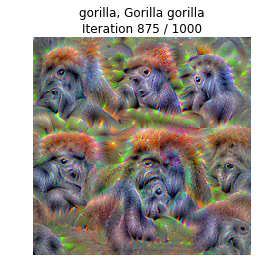

it 875 - loss 272.308960 - predicted 366 - target 366 
it 876 - loss 293.189240 - predicted 366 - target 366 
it 877 - loss 293.513580 - predicted 366 - target 366 
it 878 - loss 292.700958 - predicted 366 - target 366 
it 879 - loss 275.626282 - predicted 366 - target 366 
it 880 - loss 281.865112 - predicted 366 - target 366 
it 881 - loss 287.211182 - predicted 366 - target 366 
it 882 - loss 273.500244 - predicted 366 - target 366 
it 883 - loss 301.983124 - predicted 366 - target 366 
it 884 - loss 271.713257 - predicted 366 - target 366 
it 885 - loss 281.356232 - predicted 366 - target 366 
it 886 - loss 294.589478 - predicted 366 - target 366 
it 887 - loss 315.982086 - predicted 366 - target 366 
it 888 - loss 295.353760 - predicted 366 - target 366 
it 889 - loss 293.827515 - predicted 366 - target 366 
it 890 - loss 265.144409 - predicted 366 - target 366 
it 891 - loss 259.677979 - predicted 366 - target 366 
it 892 - loss 276.720276 - predicted 366 - target 366 
it 893 - l

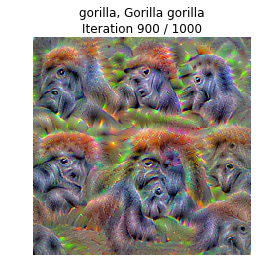

it 900 - loss 286.462219 - predicted 366 - target 366 
it 901 - loss 286.400146 - predicted 366 - target 366 
it 902 - loss 258.715118 - predicted 366 - target 366 
it 903 - loss 287.338196 - predicted 366 - target 366 
it 904 - loss 276.179626 - predicted 366 - target 366 
it 905 - loss 312.120819 - predicted 366 - target 366 
it 906 - loss 277.034698 - predicted 366 - target 366 
it 907 - loss 305.279846 - predicted 366 - target 366 
it 908 - loss 287.060364 - predicted 366 - target 366 
it 909 - loss 294.764984 - predicted 366 - target 366 
it 910 - loss 297.778656 - predicted 366 - target 366 
it 911 - loss 310.700500 - predicted 366 - target 366 
it 912 - loss 287.572571 - predicted 366 - target 366 
it 913 - loss 276.771637 - predicted 366 - target 366 
it 914 - loss 297.197296 - predicted 366 - target 366 
it 915 - loss 287.230408 - predicted 366 - target 366 
it 916 - loss 289.271454 - predicted 366 - target 366 
it 917 - loss 260.315765 - predicted 366 - target 366 
it 918 - l

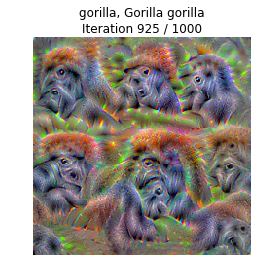

it 925 - loss 310.127563 - predicted 366 - target 366 
it 926 - loss 288.510986 - predicted 366 - target 366 
it 927 - loss 293.138702 - predicted 366 - target 366 
it 928 - loss 291.570068 - predicted 366 - target 366 
it 929 - loss 299.397156 - predicted 366 - target 366 
it 930 - loss 274.923157 - predicted 366 - target 366 
it 931 - loss 290.632660 - predicted 366 - target 366 
it 932 - loss 295.414825 - predicted 366 - target 366 
it 933 - loss 299.025970 - predicted 366 - target 366 
it 934 - loss 258.664398 - predicted 366 - target 366 
it 935 - loss 278.770935 - predicted 366 - target 366 
it 936 - loss 276.255066 - predicted 366 - target 366 
it 937 - loss 294.273926 - predicted 366 - target 366 
it 938 - loss 291.625122 - predicted 366 - target 366 
it 939 - loss 260.388641 - predicted 366 - target 366 
it 940 - loss 294.013855 - predicted 366 - target 366 
it 941 - loss 284.303772 - predicted 366 - target 366 
it 942 - loss 280.296234 - predicted 366 - target 366 
it 943 - l

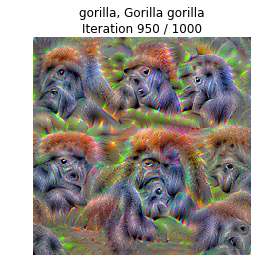

it 950 - loss 277.543610 - predicted 366 - target 366 
it 951 - loss 273.319519 - predicted 366 - target 366 
it 952 - loss 280.757904 - predicted 366 - target 366 
it 953 - loss 294.032715 - predicted 366 - target 366 
it 954 - loss 276.540924 - predicted 366 - target 366 
it 955 - loss 304.456085 - predicted 366 - target 366 
it 956 - loss 300.317078 - predicted 366 - target 366 
it 957 - loss 285.281982 - predicted 366 - target 366 
it 958 - loss 294.250000 - predicted 366 - target 366 
it 959 - loss 300.131622 - predicted 366 - target 366 
it 960 - loss 318.718597 - predicted 366 - target 366 
it 961 - loss 280.604645 - predicted 366 - target 366 
it 962 - loss 280.718597 - predicted 366 - target 366 
it 963 - loss 278.191833 - predicted 366 - target 366 
it 964 - loss 286.540741 - predicted 366 - target 366 
it 965 - loss 291.669464 - predicted 366 - target 366 
it 966 - loss 277.156860 - predicted 366 - target 366 
it 967 - loss 290.110504 - predicted 366 - target 366 
it 968 - l

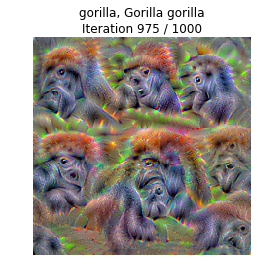

it 975 - loss 295.528778 - predicted 366 - target 366 
it 976 - loss 283.191406 - predicted 366 - target 366 
it 977 - loss 290.468872 - predicted 366 - target 366 
it 978 - loss 304.583038 - predicted 366 - target 366 
it 979 - loss 286.756378 - predicted 366 - target 366 
it 980 - loss 267.403412 - predicted 366 - target 366 
it 981 - loss 288.410858 - predicted 366 - target 366 
it 982 - loss 301.707703 - predicted 366 - target 366 
it 983 - loss 286.705261 - predicted 366 - target 366 
it 984 - loss 274.723694 - predicted 366 - target 366 
it 985 - loss 295.384857 - predicted 366 - target 366 
it 986 - loss 285.494476 - predicted 366 - target 366 
it 987 - loss 291.244232 - predicted 366 - target 366 
it 988 - loss 292.168365 - predicted 366 - target 366 
it 989 - loss 278.863159 - predicted 366 - target 366 
it 990 - loss 308.919159 - predicted 366 - target 366 
it 991 - loss 289.491150 - predicted 366 - target 366 
it 992 - loss 266.331818 - predicted 366 - target 366 
it 993 - l

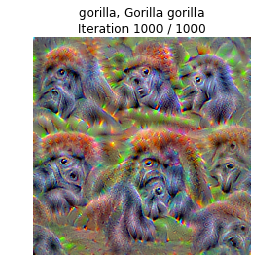

In [111]:
target_y = np.random.randint(1000)
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
target_y = 366 # Gorilla
idx = 8
X_test = X[idx][None]
#target_y = 604 # Hourglass
print(class_names[target_y])
Y = create_class_visualization(target_y, model,num_iterations=1000,X_test=X_test)